
# Случайный лес


В данном случае мы говорим об **ансамбле** решающих деревьев (отсюда и слово лес). 
В обычных деревьях для задачи классификации в листях деревьев лежит класс. Для задачи регресии в листях лежит среднее значение ответов для всех объектов. 
Чтобы получить результат работы леса, ответы отдельных деревьев должны быть как-то аггрегированы. Вопрос: Как это можно удобно сделать?


In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
import category_encoders as ce

warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Решающее дерево
Начнём с построения решающего дерева. Для демонстрации используем упрощенный датасет.

In [2]:
california = fetch_california_housing()
california_X = pd.DataFrame(data=california.data, columns=california.feature_names)
california_Y = california.target
print(f"X shape: {california_X.shape}, Y shape: {california_Y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    california_X, california_Y, test_size=0.3, random_state=123, shuffle=True
)

X shape: (20640, 8), Y shape: (20640,)


**Задание**: Ниже пример подготовки нашего датасета с домами. Проведите все действия этого ноутбука и для него. 

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# TODO: обучите решающее дерево без ограничений на тренировочной выборке
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# TODO: рассчитайте MSE на тренировочной и тестовой выборках
print(f"MSE on train set: {mean_squared_error(y_train, tree.predict(X_train)):.2f}")
print(f"MSE on test set: {mean_squared_error(y_test, tree.predict(X_test)):.2f}")

MSE on train set: 0.00
MSE on test set: 0.48


Мы видим, что наше дерево сильно переобучилось - оно идеально предсказывает значения на трейне и довольно плохо - на тесте. Заглянем в эту проблему чуть глубже. 

Среднеквадратичный риск на фиксированной выборке X можно расписать как 
$$E = Var(h) + Bias^2(h) + Noise(y)$$
Здесь $Bias^2(h) = E_x[(\overline{h}(X) - \overline{y}(X))^2]$ показывает, насколько средняя модель отклонится от матожидания таргета (идеальной модели). 
$Var(h) = E_{x,D}[(h(X, D) - \overline{h}(X))^2]$ - показывает разброс обученных моделей относительно среднего ответа. 
$Noise(y) = E_{x,y}[(\overline{y}(X) - Y)^2]$ - дисперсия самого таргета при фиксированном x. Это неустранимая ошибка, которой соответствует самый идеальный прогноз.
Описание, как оно выводится, есть [здесь](https://getsomemath.ru/) и [здесь](https://education.yandex.ru/handbook/ml/article/bias-variance-decomposition). 

Смещение показывает, насколько хорошо можно с помощью данного семейства моделей приблизиться к оптимальной модели. Как правило, оно маленькое у сложных семейств и большое у относительно простых. Вопрос: Назовите такие семейства.

Дисперсия показывает, насколько будет изменяться предсказание в зависимости от выборки - то есть насколько ваше семейство склонно к переобучению. 

Существует известный пример сочетания смещения и разброса:

![bv](../additional/images/bv.png)


На нашем примере с домами посмотрим, какие bias и variance имеет наше дерево. 

In [ ]:
def custom_bias_variance_decomp(model, X_train, y_train, X_test, y_test, n_iter=100):
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    
    predictions = np.zeros((n_iter, len(y_test)))

    for i in range(n_iter):
        X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)

        model_clone = clone(model)
        model_clone.fit(X_boot, y_boot)

        predictions[i] = model_clone.predict(X_test)

    mean_predictions = np.mean(predictions, axis=0)

    avg_loss = np.mean((predictions - y_test)**2)

    avg_bias = np.mean((mean_predictions - y_test)**2)

    avg_var = np.mean((predictions - mean_predictions[np.newaxis, :])**2)
    
    return avg_loss, avg_bias, avg_var

from sklearn.base import clone
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

avg_loss, avg_bias, avg_var = custom_bias_variance_decomp(
    tree,
    X_train,
    y_train,
    X_test,
    y_test,
    n_iter=100
)

print(f"Average test loss: {avg_loss:.4f}")
print(f"Average test bias: {avg_bias:.4f}")
print(f"Average test variance: {avg_var:.4f}")
print(f"Bias + Variance: {avg_bias + avg_var:.4f}")

Average test loss: 0.5244
Average test bias: 0.4591
Average test variance: 0.0653
Bias + Variance: 0.5244


Декомпозиция довольно долгая, так как для вычисленя средних мы много раз (по умолчанию, 200) строим подвыборки тестового сета. 

Мы видим, что у нашего дерева высокая дисперсия и низкое смещение. Постараемся исправить это. Один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

**Задание:**  Постройте графики зависимости смещения и разброса относительно глубины дерева, обученного на этом датасете.  

In [ ]:
max_depths = np.arange(1,21)
biases = []
variances = []
mses_train = []
mses_test = []

for depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, tree.predict(X_train))
    mse_test = mean_squared_error(y_test, tree.predict(X_test))
    mses_train.append(mse_train)
    mses_test.append(mse_test)

    avg_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', random_seed=42
    )
    biases.append(avg_bias)
    variances.append(avg_var)

plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.plot(max_depths, mses_train, label="Train MSE", marker="o")
plt.plot(max_depths, mses_test, label="Test MSE", marker="o")
plt.xlabel("Глубина дерева")
plt.ylabel("MSE")
plt.title('Изменение MSE относительно грубины дерева')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(max_depths, biases, label="Bias^2", marker="o", color="green")
plt.plot(max_depths, variances, label="Variance", marker="o", color="red")
plt.xlabel("Глубина дерева")
plt.ylabel("Bias^2 / Variance")
plt.title('Зависимость Bias^2 и Variance от грубины дерева')
plt.legend()
plt.grid()

plt.tight_layout()

### Бэггинг
Бэггинг основан на идее бутстрапа. Бутстрап работает на удивление просто.
Предположим, что наша выборка D размера n на представляет генеральную совокупность. После этого мы можем сгененрировать эмпирическое распределение необходимой статистики, выбирая с замещением $N >> 100$ подвыборок объема n из этой совокупности (назовем псевдовыборками), и рассчитывая для них нужную статистику. 
![bag](../additional/images/bootstrap.png)


Суть алгоритма бэггинга:
1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением.
2. Усредняем предсказания всех моделей (например, берём арифметическое среднее).

Можно показать, что модель, построенная при помощи бэггинга, будет иметь **то же смещение**, что и у отдельных деревьев, но значительно **меньшую дисперсию** (если деревья нескоррелированы - именно этогно мы пытаемся достичь в RF, семплируя фичи).  В идеальном случае дисперсия уменьшится в N раз! На практике же мы такого вряд ли добьемся, но всек же улучшения ожидать стоит. 

Для начала обучим просто беггинг - он тоже есть в sklearn, и в него можно передать любые базовые модели.

In [12]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.utils import resample

def custom_bias_variance_decomp(model, X_train, y_train, X_test, y_test, n_iter=100):
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    predictions = np.zeros((n_iter, len(y_test)))

    for i in range(n_iter):
        X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)

        model_clone = clone(model)
        model_clone.fit(X_boot, y_boot)

        predictions[i] = model_clone.predict(X_test)

    mean_predictions = np.mean(predictions, axis=0)
    avg_loss = np.mean((predictions - y_test)**2)
    avg_bias = np.mean((mean_predictions - y_test)**2)
    avg_var = np.mean((predictions - mean_predictions[np.newaxis, :])**2)
    
    return avg_loss, avg_bias, avg_var

base_tree = DecisionTreeRegressor(random_state=123)

bag = BaggingRegressor(
    base_tree, 
    n_estimators=20, 
    n_jobs=4,
    random_state=42
)

bag.fit(X_train, y_train)

print(f"MSE on train set: {mean_squared_error(y_train, bag.predict(X_train)):.4f}")
print(f"MSE on test set: {mean_squared_error(y_test, bag.predict(X_test)):.4f}")

avg_loss, avg_bias, avg_var = custom_bias_variance_decomp(
    bag,
    X_train,
    y_train,
    X_test,
    y_test,
    n_iter=100
)

print(f"\nAverage test loss: {avg_loss:.4f}")
print(f"Average test bias: {avg_bias:.4f}")
print(f"Average test variance: {avg_var:.4f}")

MSE on train set: 0.0441
MSE on test set: 0.2671

Average test loss: 0.2838
Average test bias: 0.2504
Average test variance: 0.0335


Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз! Среднеквадратичная ошибка на тренировочной и тестовой выборках ближе, причем на тестовой уменьшилась, что говорит о том, что мы уменьшили переобучение единичного дерева.


### Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем выбирать случайный набор признаков, на основе которых производится разбиение. В результате такой процедуры мы уменьшим корреляцию между деревьями, за счёт чего снизим дисперсию итоговой модели. Такой алгоритм назвывается **случайным лесом** (Random Forest).

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.
- `n_estimators` – число деревьев.


Вопрос: Как можно задать `max_features`?

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, n_jobs=4)
rf.fit(X_train, y_train)

print(f"MSE on train set: {mean_squared_error(y_train, rf.predict(X_train)):.2f}")
print(f"MSE on test set: {mean_squared_error(y_test, rf.predict(X_test)):.2f}")

avg_loss, avg_bias, avg_var = bias_variance_decomp(
    rf,
    np.array(X_train),
    np.array(y_train),
    np.array(X_test),
    np.array(y_test),
    loss="mse",
)
print(f"Average test loss: {avg_loss:.2f}")
print(f"Average test bias: {avg_bias:.2f}")
print(f"Average test variance: {avg_var:.2f}")

Как мы видим, по сравнению с простым бэггингом смещение вновь осталось практически неизменным, а дисперсия немного уменьшилась. Конечно, если подобрать хорошие гиперпараметры, то получится снизить дисперсию ещё больше. 

Ошибка на тренировочной выборке увеличилась, а на тестовой — уменьшилась, что означает, что мы добились нашей цели в борьбе с переобученными деревьями!

**Дополнительное задание:** Постройте какую-нибудь несложную функцию и постройте на одном графике предсказания деревьев, обученных на выборках с добавленым шумом для такой функции.
Далее постройте такой же график, но для бэггингов, обученных на подвыборках. Для сравнения число семплов, которое вы выбирали для одного дерева (например, 50), должно остаться таким же для одного дерева в бэггинге. Для обучения бэггинга используйте больше семплов (50*n_trees). 
Ожидаемо вы увидете, что среднее предсказаний будет таким же (тот же Bias), но отдельные предсказания станут ближе к реальной зависимости (меньше Var).


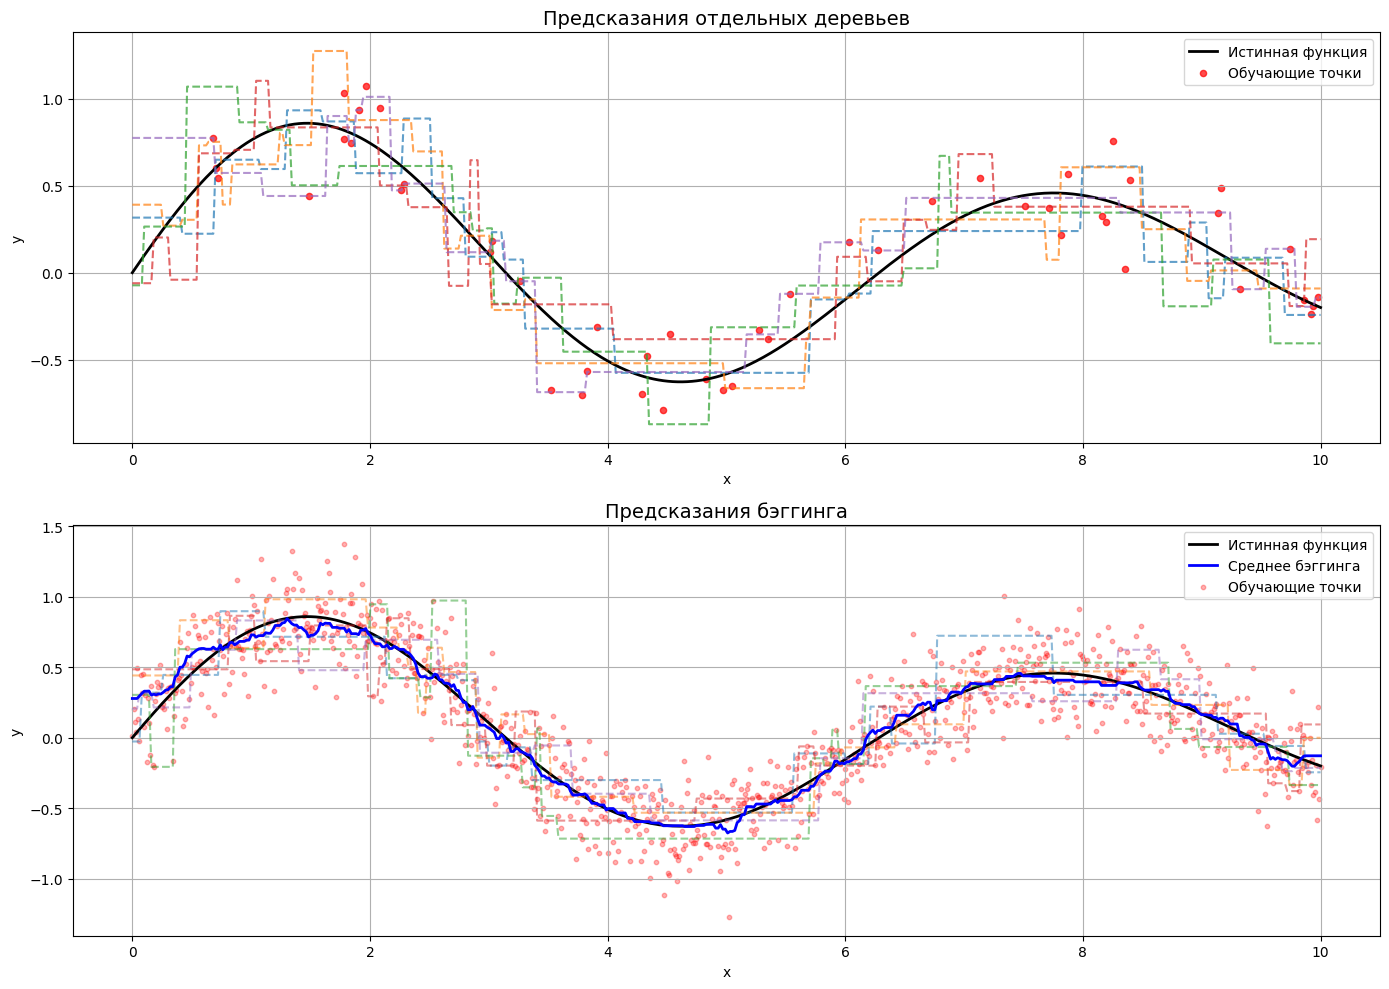


Сравнение смещения и дисперсии:
Одно дерево: Смещение = 0.0007, Дисперсия = 0.0346
Бэггинг:    Смещение = 0.0005, Дисперсия = 0.0025
Уменьшение дисперсии: 92.9%


In [ ]:
def true_function(x):
    return np.sin(x) * np.exp(-0.1 * x)

np.random.seed(42)
X = np.linspace(0, 10, 500).reshape(-1, 1)
y = true_function(X).ravel()

n_samples = 50
n_trees = 20

def create_noisy_samples(X, y, n_samples, noise_level=0.2):
    """Создает подвыборку с добавлением шума и бутстрэпом"""
    indices = np.random.choice(len(X), n_samples, replace=True)
    X_sample = X[indices]
    y_sample = y[indices] + np.random.normal(0, noise_level, n_samples)
    return X_sample, y_sample

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title("Предсказания отдельных деревьев", fontsize=14)
plt.plot(X, y, 'k-', linewidth=2, label="Истинная функция")

for i in range(5):
    X_sample, y_sample = create_noisy_samples(X, y, n_samples)
    tree = DecisionTreeRegressor(max_depth=5, random_state=i)
    tree.fit(X_sample, y_sample)
    y_pred = tree.predict(X)
    plt.plot(X, y_pred, alpha=0.7, linestyle='--')

plt.scatter(X_sample, y_sample, s=20, c='red', alpha=0.7, label="Обучающие точки")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Предсказания бэггинга", fontsize=14)
plt.plot(X, y, 'k-', linewidth=2, label="Истинная функция")

X_big = np.linspace(0, 10, n_samples * n_trees).reshape(-1, 1)
y_big = true_function(X_big).ravel() + np.random.normal(0, 0.2, n_samples * n_trees)

bag = BaggingRegressor(
    DecisionTreeRegressor(max_depth=5),
    n_estimators=n_trees,
    max_samples=n_samples,
    bootstrap=True,
    random_state=42
)
bag.fit(X_big, y_big)

for i, tree_in_bag in enumerate(bag.estimators_):
    if i < 5:
        y_pred = tree_in_bag.predict(X)
        plt.plot(X, y_pred, alpha=0.5, linestyle='--')

y_bag_pred = bag.predict(X)
plt.plot(X, y_bag_pred, 'b-', linewidth=2, label="Среднее бэггинга")

plt.scatter(X_big, y_big, s=10, c='red', alpha=0.3, label="Обучающие точки")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def calculate_bias_variance(model, X_true, y_true, X_test, n_samples, n_iter=100):
    """Вычисляет смещение и дисперсию модели"""
    predictions = np.zeros((n_iter, len(X_test)))
    
    for i in range(n_iter):
        X_sample, y_sample = create_noisy_samples(X_true, y_true, n_samples)
        model_clone = DecisionTreeRegressor(max_depth=5).fit(X_sample, y_sample)
        predictions[i] = model_clone.predict(X_test)
    
    mean_predictions = np.mean(predictions, axis=0)
    bias = np.mean((mean_predictions - y_true)**2)
    variance = np.mean(np.var(predictions, axis=0))
    
    return bias, variance

bias_tree, var_tree = calculate_bias_variance(
    DecisionTreeRegressor(max_depth=5), 
    X, y, X, n_samples
)

def calculate_bias_variance_bag(bag_model, X_true, y_true, X_test, n_samples, n_trees, n_iter=100):
    predictions = np.zeros((n_iter, len(X_test)))
    
    for i in range(n_iter):
        X_big = np.linspace(0, 10, n_samples * n_trees).reshape(-1, 1)
        y_big = true_function(X_big).ravel() + np.random.normal(0, 0.2, n_samples * n_trees)

        bag_model.fit(X_big, y_big)
        predictions[i] = bag_model.predict(X_test)
    
    mean_predictions = np.mean(predictions, axis=0)
    bias = np.mean((mean_predictions - y_true)**2)
    variance = np.mean(np.var(predictions, axis=0))
    
    return bias, variance

bag_model = BaggingRegressor(
    DecisionTreeRegressor(max_depth=5),
    n_estimators=n_trees,
    max_samples=n_samples,
    bootstrap=True
)

bias_bag, var_bag = calculate_bias_variance_bag(
    bag_model, 
    X, y, X, 
    n_samples, n_trees
)

print("\nСравнение смещения и дисперсии:")
print(f"Одно дерево: Смещение = {bias_tree:.4f}, Дисперсия = {var_tree:.4f}")
print(f"Бэггинг:    Смещение = {bias_bag:.4f}, Дисперсия = {var_bag:.4f}")
print(f"Уменьшение дисперсии: {100*(var_tree - var_bag)/var_tree:.1f}%")

## Особенности случайного леса
Много важных свойств леса описал в своём [блоге](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks) Лео Бриман (Leo Breiman), создатель случайного леса. Рассмотрим часть из них.
Дополнительно: [статья от основ к практике](https://arxiv.org/pdf/1407.7502)
### Число деревьев и "Случайный лес не переобучается"
Cлучайный лес не переобучается именно с ростом числа деревьев (за счёт совместной работы бэггинга и использования случайных подпространств), но не в принципе. Посмотрим на поведение случайного леса при росте числа деревьев.

100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


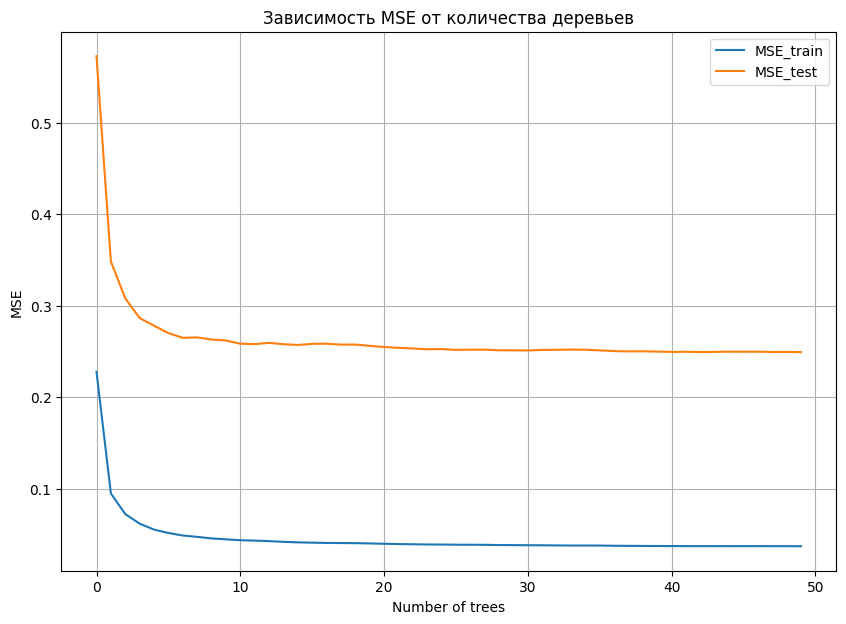

In [17]:
from sklearn.ensemble import RandomForestRegressor
n_trees = 100
train_loss = []
test_loss = []

for i in trange(1, n_trees, 2):
    rf = RandomForestRegressor(n_estimators=i, random_state=123, n_jobs=4)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 7))
plt.title("Зависимость MSE от количества деревьев")
plt.grid()
plt.plot(train_loss, label="MSE_train")
plt.plot(test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("Number of trees")
plt.legend();

Как и ожидалось, по достижении некоторого числа деревьев обе ошибки практически не изменяются, то есть дальнейшего переобучения при росте числа деревьев не происходит. Поэтому на практике основное ограничение -бюджет на обучение.

При изменении какого-нибудь другого параметра на реальных данных переобучение может произойти. Например, случайный лес с ограниченными по глубине деревьями может предсказывать более точно, чем лес без ограничений. Примеры: [пример 1](https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit), [пример 2](https://mljar.com/blog/random-forest-overfitting/).
Посмотрим, какой будет ошибка в зависимости от глубины.

**Задание**: Постройте график зависимости от глубины. Наблюдается ли переобучение?

100%|██████████| 50/50 [03:16<00:00,  3.93s/it]


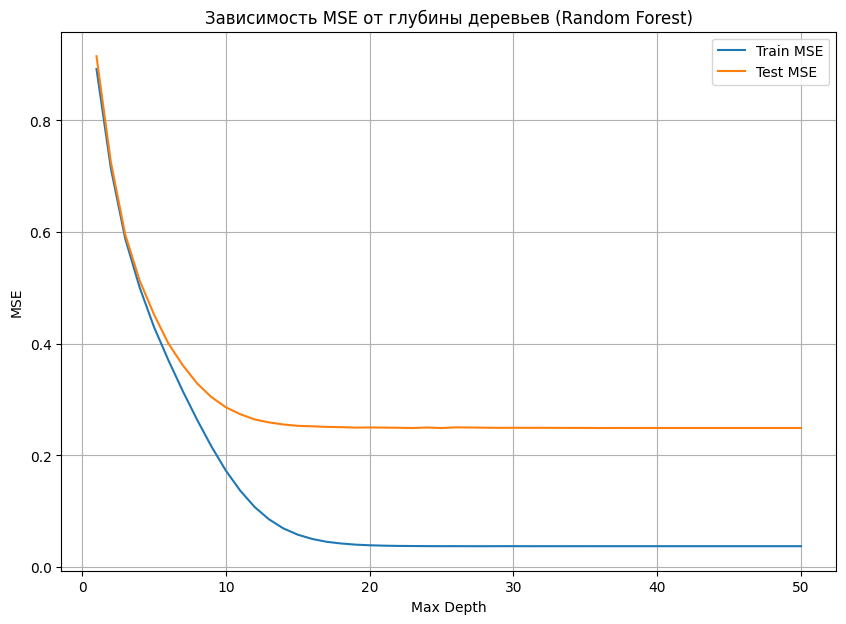

In [18]:
max_depths = range(1, 51)
train_loss = []
test_loss = []

for depth in trange(1, 51):
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=depth,
        random_state=123,
        n_jobs=4
    )
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 7))
plt.title("Зависимость MSE от глубины деревьев (Random Forest)")
plt.grid()
plt.plot(max_depths, train_loss, label="Train MSE")
plt.plot(max_depths, test_loss, label="Test MSE")
plt.ylabel("MSE")
plt.xlabel("Max Depth")
plt.legend()

**Задание**: Постройте график зависимости от числа признаков в сплите (max_features). Наблюдается ли переобучение?

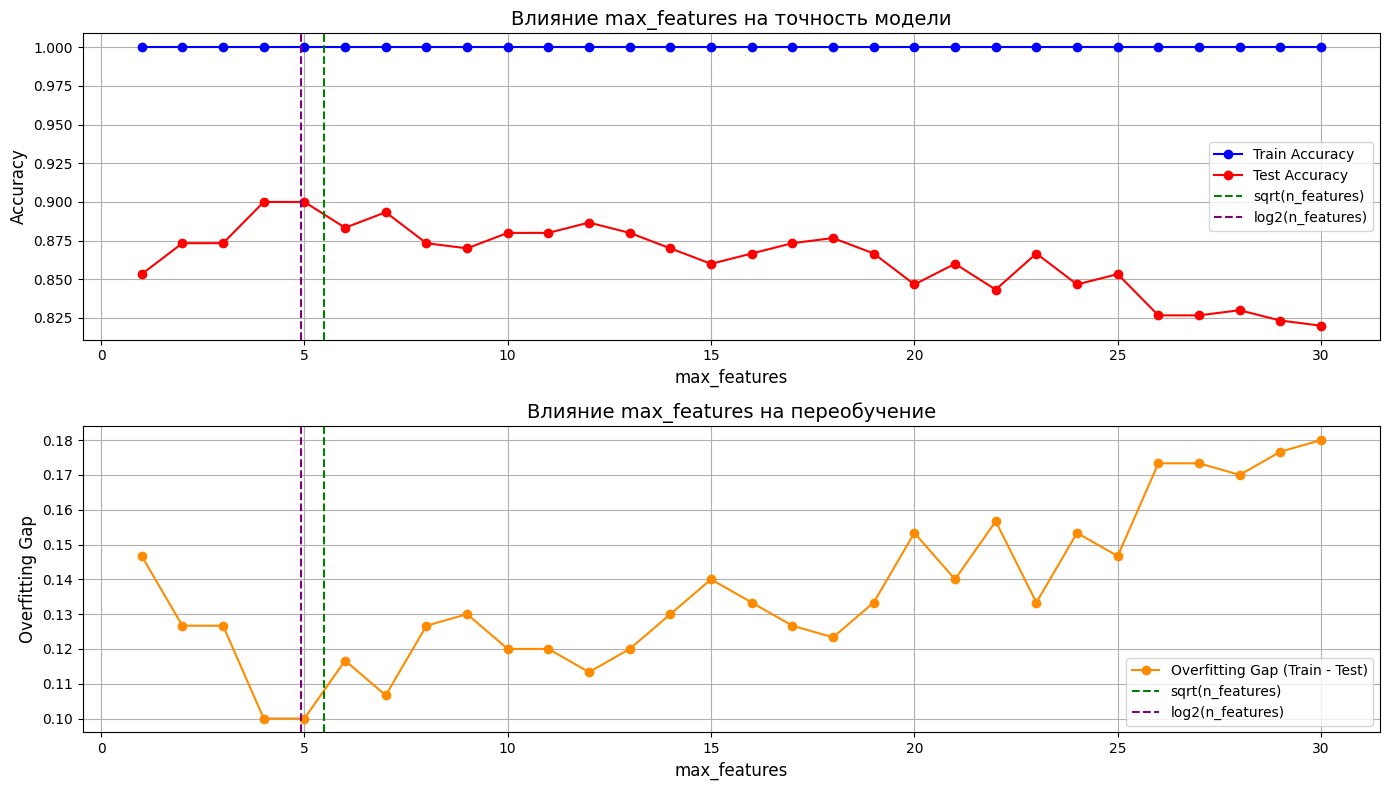

Оптимальное значение max_features: 4
Точность на тесте при оптимальном max_features: 0.9000


In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=15,
    n_redundant=10,
    n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

max_features_range = np.arange(1, X.shape[1] + 1)
train_scores = []
test_scores = []
overfitting_gaps = []

for max_features in max_features_range:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=max_features,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    overfitting_gaps.append(train_acc - test_acc)

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(max_features_range, train_scores, 'o-', color='blue', label='Train Accuracy')
plt.plot(max_features_range, test_scores, 'o-', color='red', label='Test Accuracy')
plt.axvline(x=np.sqrt(X.shape[1]), color='green', linestyle='--', label='sqrt(n_features)')
plt.axvline(x=np.log2(X.shape[1]), color='purple', linestyle='--', label='log2(n_features)')

plt.title('Влияние max_features на точность модели', fontsize=14)
plt.xlabel('max_features', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(max_features_range, overfitting_gaps, 'o-', color='darkorange', label='Overfitting Gap (Train - Test)')
plt.axvline(x=np.sqrt(X.shape[1]), color='green', linestyle='--', label='sqrt(n_features)')
plt.axvline(x=np.log2(X.shape[1]), color='purple', linestyle='--', label='log2(n_features)')

plt.title('Влияние max_features на переобучение', fontsize=14)
plt.xlabel('max_features', fontsize=12)
plt.ylabel('Overfitting Gap', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

optimal_idx = np.argmax(test_scores)
print(f"Оптимальное значение max_features: {max_features_range[optimal_idx]}")
print(f"Точность на тесте при оптимальном max_features: {test_scores[optimal_idx]:.4f}")

Вопрос: Как думаете, какую глубину чтоит выбирать? А если вспомнить о bias и variance?

### 3.2. Out-of-bag-ошибка

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. В каждую подвыборку, таким образом, часть наблюдений попадет несколько раз, а часть ни разу. 

Какая вероятность, что семпл не попадет в подвыборку? Пусть в выборке $n$ наблюдений. Тогда вероятность семпла попасть в выборку с повторениями 1 раз - $1/n$. Не попасть - $1 - 1/n$. Бутстрап строит подвыборку размера n. Вероятность не попасть в подвыборку n раз тогда - $(1 - 1/n)^n$. Оценим асимптотику. При $ \lim_{n -> \inf}{(1 - 1/n)^n}$ сводится к замечательному пределу $(1 + 1/u)^u -> e $. 
В результате получаем $1/e \approx 0.37$.

А это значит, что мы можем получить оценку качества модели **бесплатно**! В случае MSE мы можем использовать MSE, а точности - error rate. Такая оценка называется **out-of-bag-ошибкой**. 

То, как конкретно она считается, зависит от реализации, но в целом алгоритм следующий: 
- Для каждого out-of-bag примера находим все модели, которые на нем не обучались.
- Голосованием определяем значение предсказание этих моделей. Считаем соответствующую оценку
- Считаем среднюю оценку на всех таких семплах.


In [20]:
# oob_score_ = R2 на невиденных наблюдениях
rf = RandomForestRegressor(n_estimators=100, random_state=123, oob_score=True, n_jobs=4)
rf.fit(X_train, y_train)
rf.oob_score_

0.5610472092161118

Вопрос: как OOB ошибка связана с оценкой на кросс-валидации?

В OOB каждое дерево проверяется на ≈37% данных, которые не вошли в его бутстрап-выборку, а в CV модель обучается на (K-1)/K данных и проверяется на 1/K данных.

Важно: при небольшом количестве деревьев оценка будет неточной. 

**Задание:** постройте график зависимости OOB ошибки для количества деревьев и их глубины.

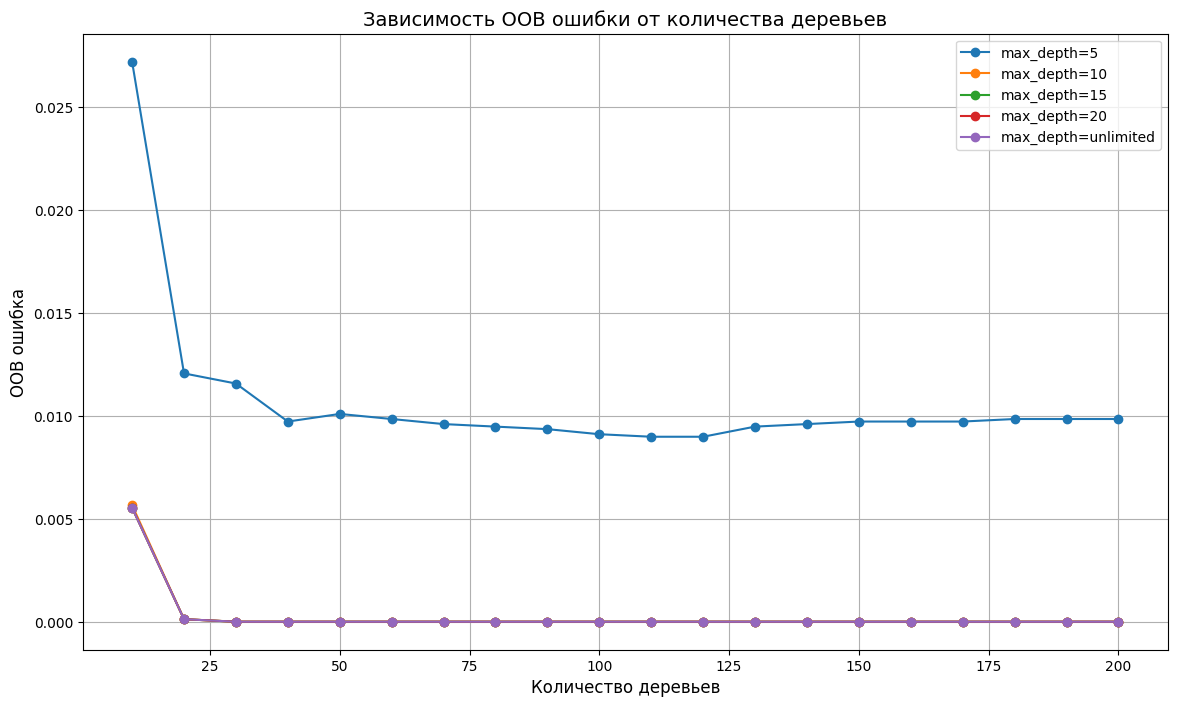

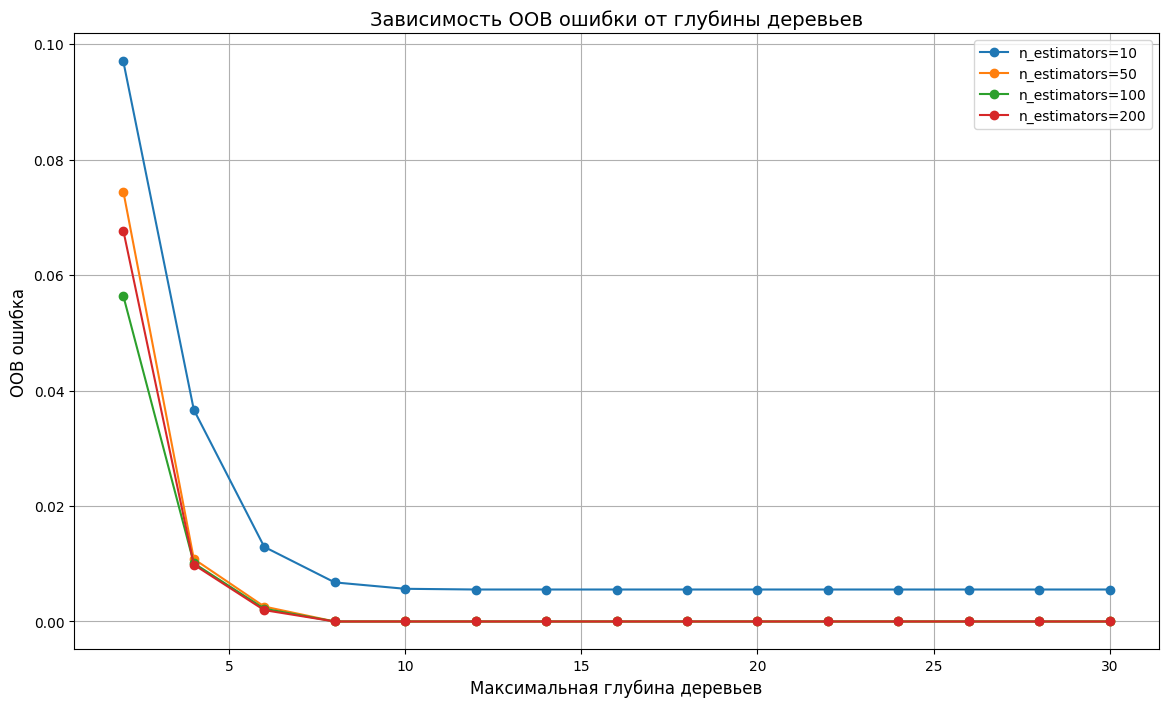

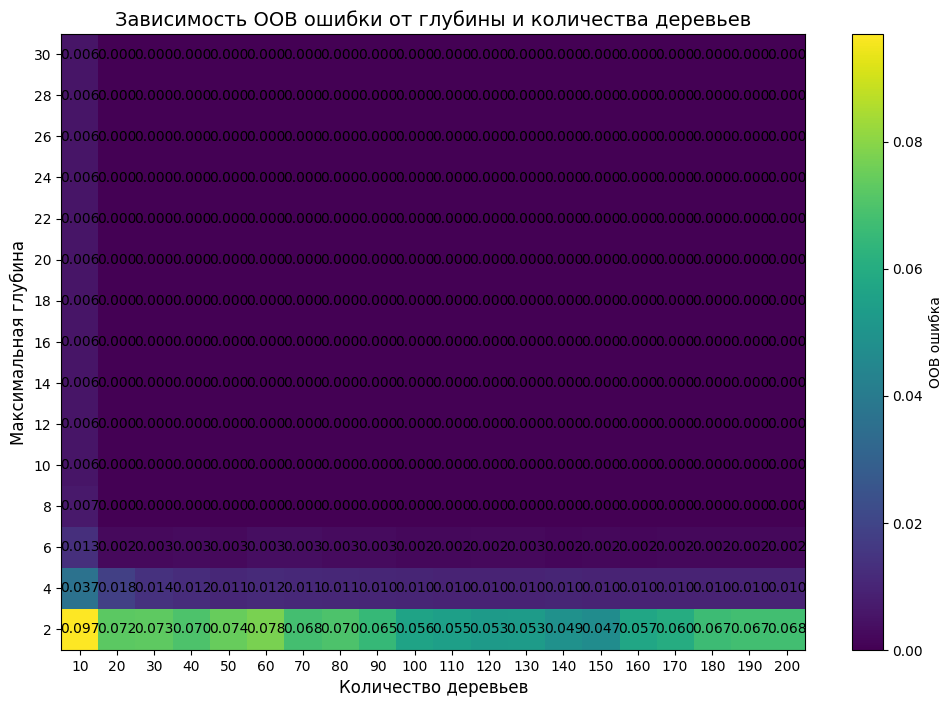

In [ ]:
cfg = {
    'classification': {
        'mushrooms': 'mushrooms.tar/mushrooms.csv'  
    }
}
df = pd.read_csv(cfg["classification"]["mushrooms"])

X = pd.get_dummies(df.drop('class', axis=1))
y = df['class'].map({'e': 0, 'p': 1})

plt.figure(figsize=(14, 8))
depths = [5, 10, 15, 20, None]
n_estimators_range = np.arange(10, 210, 10)

for depth in depths:
    oob_errors = []
    for n in n_estimators_range:
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=depth,
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X, y)
        oob_errors.append(1 - rf.oob_score_)
    
    label = f"max_depth={'unlimited' if depth is None else depth}"
    plt.plot(n_estimators_range, oob_errors, 'o-', label=label)

plt.title('Зависимость OOB ошибки от количества деревьев', fontsize=14)
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('OOB ошибка', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))
depths_range = np.arange(2, 31, 2)
n_estimators_list = [10, 50, 100, 200]

for n_est in n_estimators_list:
    oob_errors = []
    for depth in depths_range:
        rf = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X, y)
        oob_errors.append(1 - rf.oob_score_)
    
    plt.plot(depths_range, oob_errors, 'o-', label=f"n_estimators={n_est}")

plt.title('Зависимость OOB ошибки от глубины деревьев', fontsize=14)
plt.xlabel('Максимальная глубина деревьев', fontsize=12)
plt.ylabel('OOB ошибка', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

oob_matrix = np.zeros((len(depths_range), len(n_estimators_range)))

for i, depth in enumerate(depths_range):
    for j, n in enumerate(n_estimators_range):
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=depth,
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X, y)
        oob_matrix[i, j] = 1 - rf.oob_score_

plt.figure(figsize=(12, 8))
plt.imshow(oob_matrix, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='OOB ошибка')

plt.xticks(np.arange(len(n_estimators_range)), n_estimators_range)
plt.yticks(np.arange(len(depths_range)), depths_range)

plt.title('Зависимость OOB ошибки от глубины и количества деревьев', fontsize=14)
plt.xlabel('Количество деревьев', fontsize=12)
plt.ylabel('Максимальная глубина', fontsize=12)

for i in range(len(depths_range)):
    for j in range(len(n_estimators_range)):
        plt.text(j, i, f'{oob_matrix[i, j]:.3f}', 
                 ha='center', va='center', 
                 color='white' if oob_matrix[i, j] > 0.5 else 'black')

plt.show()

### 3.3. Важность признаков
Как и решающие деревья, случайный лес позволяет оценивать важность признаков. Важность признаков можно оценивать, например, с помощью
**Gini Importance**.
Для одного дерева: при каждом разбиении по некоторому признаку, считаем Impurity decrease, взвешиваем по числу семплов в сплите и сохраняем результат. В конце суммируем.
Лес расширяет эту оценку: считается среднее важности признака по всем деревьям.
Однако тогда мы сталкиваемся с такой проблемой, что приоритет отдается признакам с большим числом уровней.

Более правильный способ (но и более затратный) -  **Permurtation importance**.
Для каждого дерева берется OOB семпл и считается количество голосов, отданных за правильный класс. Далее случайным образом перемешиваются значения переменной m в OOB и количество голосов, отданных за правильный класс, пересчитиывается.Далее одно вычитается из другого. Среднее  значение этой разницы по всем деревьям в лесу является необработанной оценкой важности для переменной m. 

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(california["feature_names"], rf.feature_importances_);

Однако такие оценки опасны в случае коррелирующих признаков. Посмотрим, что произойдёт с важностью, если добавить в выборку линейно зависимый признак.

In [ ]:
RM_mc = np.array((X_train.iloc[:, 5] * 2 + 3)).reshape(-1, 1)
X_train_new = np.hstack((X_train, RM_mc))

In [ ]:
rf.fit(X_train_new, y_train)

In [ ]:
plt.figure(figsize=(10, 7))
names = list(california["feature_names"])
names.append("_AveOccup")
plt.bar(names, rf.feature_importances_);

Важности перераспределились между линейной зависимыми признаками `AveOccup` и `_AveOccup`.  Поэтому такая оценка не обязательно четко отражает действительность. 

**Задание**: Посчитайте важности с помощью permutation importance.


In [ ]:
from sklearn.inspection import permutation_importance

rf = RandomForestRegressor(n_estimators=20, random_state=123, n_jobs=4)
rf.fit(X_train, y_train)

perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=123, n_jobs=4
)

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, perm_importance.importances_mean)
plt.title("Permutation Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Что еще

В библиотеке scikit-learn есть реализация ExtraTreesClassifier и ExtraTreesRegressor. Данный метод стоит использовать, если вы наблюдаете сильное переобучение на случайном лесе или градиентном бустинге.

Случайный лес не очень хорошо работает для сильно разреженных данных.

Как и одно дерево, RF не умеет экстраполировать.

Для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокое значение информативности

RF хорошо параллелизуются, поэтому можно ускорить их обучение )
